## 导入库

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("garch预测.csv")

## 时序图

In [4]:
# 绘制每日回报(因为数据太多，选取一年进行绘制)

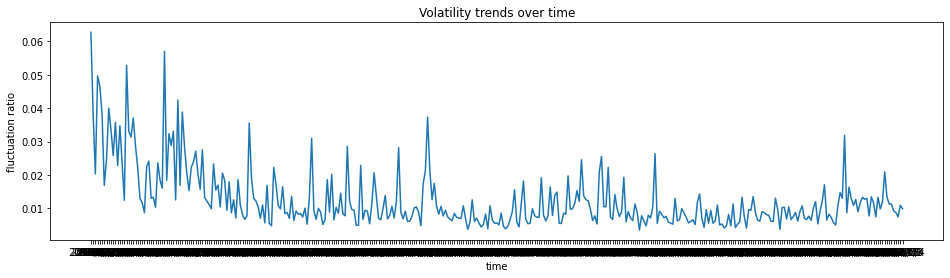

In [5]:
dev_x = data['时间']
dev_y = data['波动率']

dev_x = dev_x[:365]
dev_y = dev_y[:365]

plt.subplots(figsize=(16,4))
plt.plot(dev_x, dev_y)
plt.xlabel("time")
plt.ylabel("fluctuation ratio")
plt.title("Volatility trends over time")
plt.show()

整体呈上下波动趋势，个别时间点波动性较大。

## 自相关图（ACF-MA)、偏自相关图(PACF-AR）

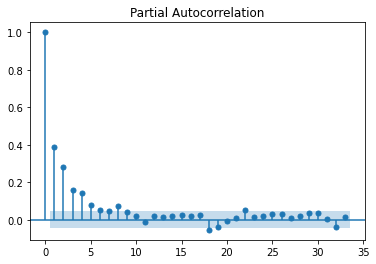

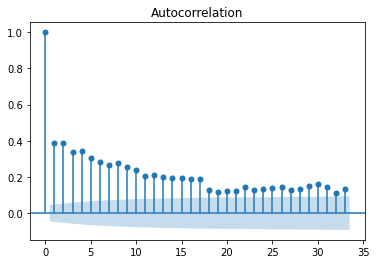

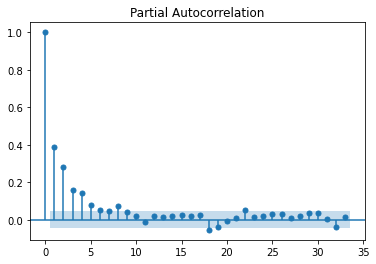

In [6]:
#股票每日波动率自相关图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

b = data['波动率']
plot_acf(b)
plot_pacf(b)

可以看到偏自相关系数截尾，自相关系数拖尾，要做差分处理。自相关拖尾，偏相关截尾，用AR算法

## 单位根检验

In [7]:
from statsmodels.tsa.stattools import adfuller as ADF
print('原始序列数据的ADF检测结果为：')
print(ADF(data['波动率']))
# 返回值依次为： adf, pvalue(单位根，>=0.05就是非平稳序列)

原始序列数据的ADF检测结果为：
(-7.932311360774264, 3.4866350209207472e-12, 8, 1806, {'1%': -3.433976034843506, '5%': -2.8631416925158244, '10%': -2.5676226884667694}, -12939.99704726051)


In [23]:
#adf检验平稳性
from statsmodels.tsa.stattools import adfuller
yarn_result = adfuller(b) #生成adf检验结果

print('The ADF Statistic of yarn yield: %f' % yarn_result[0])
print('The p value of yarn yield: %f' % yarn_result[1])



The ADF Statistic of yarn yield: -7.932311
The p value of yarn yield: 0.000000


p值为零，说明是拒绝原假设，表明该序列是一个平稳序列

## 白噪声检验

In [22]:
#检验白噪声
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(b, lags = [6, 12],boxpierce=True)

(array([1282.27874593, 1940.82695436]),
 array([7.4291281e-274, 0.0000000e+000]),
 array([1278.65941921, 1933.16550853]),
 array([4.51246005e-273, 0.00000000e+000]))

因为有p值不大于0.05，不可以拒绝原假设，该数据序列非随机序列。没有通过白噪声检验，则需要进行模型识别，识别其模型属于AR、MA还是ARMA。

In [19]:
data

,时间,波动率
0,2016/1/4,0.062748
1,2016/1/5,0.038185
2,2016/1/6,0.020324
3,2016/1/7,0.049676
4,2016/1/8,0.046614
...,...,...
1810,2023/6/14,0.009309
1811,2023/6/15,0.011919
1812,2023/6/16,0.008815
1813,2023/6/19,0.013379


## 模型残差检验

ARIMA的残差是否是平均值为0且方差为常数的正太分布

In [ ]:
import pandas as pd# 创建一个时间序列数据帧
time_series = pd.DataFrame(data["波动率"], index=data["时间"], columns=['values'])


## QQ图

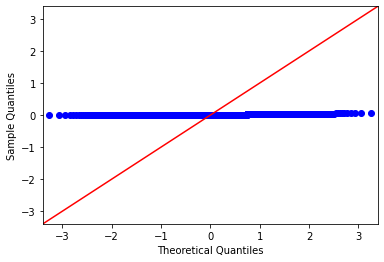

In [36]:
#qq图
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 创建 Q-Q 图，并增加 45度线
fig = sm.qqplot(data["波动率"], line='45')
plt.show()


显然图中显示数据不遵循红色的45度线，这表明它们不服从正态分布。

In [10]:
inputfile2 = 'attrsConstruction.xlsx'
data1 = data
data1 = data1.iloc[:len(data1)-5]# 不使用最后五个数据（作为预测参考）
 
# 白噪声检测
from statsmodels.stats.diagnostic import acorr_ljungbox
 
[[lb], [p]] = acorr_ljungbox(data1['波动率'], lags = 1) ## lags是残差延迟个数
if p < 0.05:
    print (u'原始序列为非白噪声序列，对应的p值为：%s' % p)
else:
    print (u'原始序列为白噪声序列，对应的p值为：%s' % p)
 
[[lb], [p]] = acorr_ljungbox(data1['波动率'].diff(2).dropna(), lags = 1)
if p < 0.05:
    print (u'二阶差分序列为非白噪声序列，对应的p值为：%s' % p)
else:
    print (u'二阶差分序列为白噪声序列，对应的p值为：%s' % p)


原始序列为非白噪声序列，对应的p值为：8.485656191912463e-61
二阶差分序列为白噪声序列，对应的p值为：0.10042158231588151


## 差分运算

In [11]:
data1['二阶差分'] = data1['波动率'].diff(2)

In [16]:
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA

# return_df见下面的[研究]部分
order_analyze = st.arma_order_select_ic(data1['波动率'], max_ar=5, max_ma=5, ic=['aic', 'bic'])
order_analyze

{'aic':               0            1             2            3             4  \
 0 -12435.375548 -12619.70876 -12746.706644 -12790.80719 -12849.401276   
 1 -12732.738760          NaN           NaN          NaN           NaN   
 2 -12885.447430          NaN           NaN          NaN           NaN   
 3 -12928.793369          NaN           NaN          NaN           NaN   
 4 -12968.535497          NaN           NaN          NaN           NaN   
 5 -12980.857289          NaN           NaN          NaN           NaN   
 
               5  
 0 -12877.206555  
 1           NaN  
 2           NaN  
 3           NaN  
 4           NaN  
 5           NaN  ,
 'bic':               0             1             2             3             4  \
 0 -12424.373384 -12603.205514 -12724.702316 -12763.301779 -12816.394783   
 1 -12716.235514           NaN           NaN           NaN           NaN   
 2 -12863.443101           NaN           NaN           NaN           NaN   
 3 -12901.287958           N

aic_min_order: (5, 0) 意味着在模型选择过程中，AIC准则推荐使用(5, 0)作为最优的模型阶数。这里的 (5, 0) 表示AR（自回归）模型阶数为5，MA（移动平均）模型阶数为0。

    
bic_min_order: (5, 0) 意味着在模型选择过程中，BIC准则推荐使用(5, 0)作为最优的模型阶数。与前面类似，(5, 0) 表示AR模型阶数为5，MA模型阶数为0。

Text(0.5, 1.0, 'BIC')

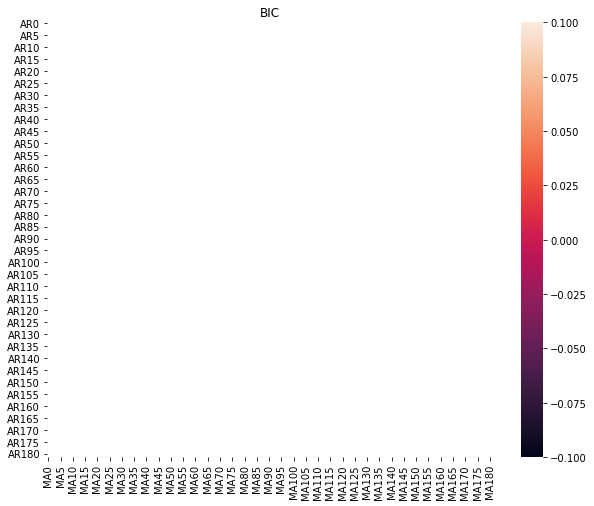

In [17]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(bic_matrix,
                mask = bic_matrix.isnull(),
                ax = ax,
                annot = True,
                fmt='.2f')
ax.set_title('BIC')

In [17]:
from arch import arch_model
from arch.__future__ import reindexing

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  war

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  war

Text(0.5, 1.0, 'Rolling Prediction')

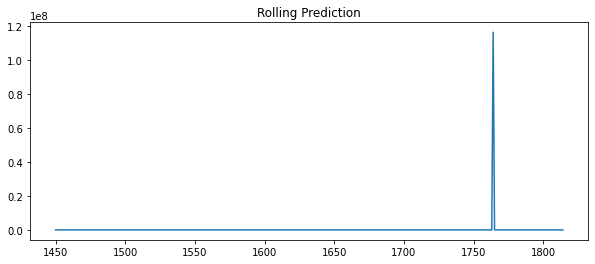

In [20]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = data['波动率'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=data['波动率'].index[-365:])

fig,ax = plt.subplots(figsize=(10,4))

plt.plot(rolling_predictions)
plt.title('Rolling Prediction')